In [1]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime
import pickle

from scipy import stats
from scipy.special import boxcox1p

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from itertools import product

import gc

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from numba import jit

In [3]:
@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)



In [4]:
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc

In [5]:
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    is_higher_better = True
    return 'MCC', best_mcc, is_higher_better

In [6]:
meta_train = pd.read_csv('../input/metadata_train.csv')
meta_test = pd.read_csv('../input/metadata_test.csv')

In [7]:
numpeaks = np.load('../features/numpeaks.npy')
numpospeaks = np.load('../features/numpospeaks.npy')
numnegpeaks = np.load('../features/numnegpeaks.npy')

maxpeakwidth = np.load('../features/maxpeakwidth.npy')
minpeakwidth = np.load('../features/minpeakwidth.npy')
meanpeakwidth = np.load('../features/meanpeakwidth.npy')
maxamp = np.load('../features/maxamp.npy')
minamp = np.load('../features/minamp.npy')
meanamp = np.load('../features/meanamp.npy')

stdampall = np.load('../features/stdampall.npy')
stdposall = np.load('../features/stdposall.npy')
stdwidthall = np.load('../features/stdwidthall.npy')

stdampq2 = np.load('../features/stdampq2.npy')
stdposq2 = np.load('../features/stdposq2.npy')
stdwidthq2 = np.load('../features/stdwidthq2.npy')
stdampq3 = np.load('../features/stdampq3.npy')
stdposq3 = np.load('../features/stdposq3.npy')
stdwidthq3 = np.load('../features/stdwidthq3.npy')
stdampq4 = np.load('../features/stdampq4.npy')
stdposq4 = np.load('../features/stdposq4.npy')
stdwidthq4 = np.load('../features/stdwidthq4.npy')


In [8]:
stdampall_ad = np.load('../features/stdampall_ad.npy')
stdampq2_ad = np.load('../features/stdampq2_ad.npy')
stdampq3_ad = np.load('../features/stdampq3_ad.npy')
stdampq4_ad = np.load('../features/stdampq4_ad.npy')

meanampall_ad = np.load('../features/meanampall_ad.npy')
meanampq2_ad = np.load('../features/meanampq2_ad.npy')
meanampq3_ad = np.load('../features/meanampq3_ad.npy')
meanampq4_ad = np.load('../features/meanampq4_ad.npy')

meanamppos = np.load('../features/meanamppos.npy')
meanampneg = np.load('../features/meanampneg.npy')


In [9]:
numpeaks_id = np.load('../features/numpeaks_id.npy')
numpospeaks_id = np.load('../features/numpospeaks_id.npy')
numnegpeaks_id = np.load('../features/numnegpeaks_id .npy')

maxamp_id = np.load('../features/maxamp_id.npy')
minamp_id = np.load('../features/minamp_id.npy')
meanamp_id = np.load('../features/meanamp_id.npy')

meanamppos_id = np.load('../features/meanamppos_id.npy')
meanampneg_id = np.load('../features/meanampneg_id.npy')


In [10]:
stdamp_id = np.load('../features/stdamp_id.npy')
stdamppos_id = np.load('../features/stdamppos_id.npy')
stdampneg_id = np.load('../features/stdampneg_id.npy')

numpeaksq2_id = np.load('../features/numpeaksq2_id.npy')
numpeaksq3_id = np.load('../features/numpeaksq3_id.npy')
numpeaksq4_id = np.load('../features/numpeaksq4_id.npy')

numpospeaksq2_id = np.load('../features/numpospeaksq2_id.npy')
numpospeaksq3_id = np.load('../features/numpospeaksq3_id.npy')
numpospeaksq4_id = np.load('../features/numpospeaksq4_id.npy')

numnegpeaksq2_id = np.load('../features/numnegpeaksq2_id.npy')
numnegpeaksq3_id = np.load('../features/numnegpeaksq3_id.npy')
numnegpeaksq4_id = np.load('../features/numnegpeaksq4_id.npy')

coefampq2q3_id = np.load('../features/coefampq2q3_id.npy')
coefampq2q4_id = np.load('../features/coefampq2q4_id.npy')

stdampq2_id = np.load('../features/stdampq2_id.npy')
stdampq3_id = np.load('../features/stdampq3_id.npy')
stdampq4_id = np.load('../features/stdampq4_id.npy')

stdposampq2_id = np.load('../features/stdposampq2_id.npy')
stdposampq3_id = np.load('../features/stdposampq3_id.npy')
stdposampq4_id = np.load('../features/stdposampq4_id.npy')

stdnegampq2_id = np.load('../features/stdnegampq2_id.npy')
stdnegampq3_id = np.load('../features/stdnegampq3_id.npy')
stdnegampq4_id = np.load('../features/stdnegampq4_id.npy')

meanampq2_id = np.load('../features/meanampq2_id.npy')
meanampq3_id = np.load('../features/meanampq3_id.npy')
meanampq4_id = np.load('../features/meanampq4_id.npy')

meanposampq2_id = np.load('../features/meanposampq2_id.npy')
meanposampq3_id = np.load('../features/meanposampq3_id.npy')
meanposampq4_id = np.load('../features/meanposampq4_id.npy')

meannegampq2_id = np.load('../features/meannegampq2_id.npy')
meannegampq3_id = np.load('../features/meannegampq3_id.npy')
meannegampq4_id = np.load('../features/meannegampq4_id.npy')

In [11]:
train_features = pd.DataFrame({'NumPeaks':numpeaks, 'NumPosPeaks':numpospeaks, 'NumNegPeaks':numnegpeaks, 'MaxWidth':maxpeakwidth,
                         'MinWidth':minpeakwidth, 'MeanWidth':meanpeakwidth, 'MaxAmp':maxamp, 'MinAmp':minamp, 'MeanAmp':meanamp,
                        'StdAmpAll':stdampall, 'StdPosAll':stdposall, 'StdWidthAll':stdwidthall, 'StdAmpQ2':stdampq2, 'StdPosQ2':stdposq2,
                         'StdWidthQ2':stdwidthq2, 'StdAmpQ3':stdampq3, 'StdPosQ3':stdposq3, 'StdWidthQ3':stdwidthq3,
                        'StdAmpQ4':stdampq4, 'StdPosQ4':stdposq4, 'StdWidthQ4':stdwidthq4, 
                        'StdAmpAll_AD':stdampall_ad, 'StdAmpQ2_AD': stdampq2_ad, 'StdAmpQ3_AD': stdampq3_ad, 'StdAmpQ4_AD': stdampq4_ad,
                        'MeanAmpAll_AD':meanampall_ad, 'MeanAmpQ2_AD': meanampq2_ad,
                        'MeanAmpQ3_AD': meanampq3_ad, 'MeanAmpQ4_AD': meanampq4_ad,
                        'MeanAmpPos':meanamppos, 'MeanAmpNeg':meanampneg,
                        'NumPeaks_ID':numpeaks_id, 'NumPosPeaks_ID':numpospeaks_id, 'NumNegPeaks_ID':numnegpeaks_id,
                        'MaxAmp_ID':maxamp_id, 'MinAmp_ID':minamp_id, 'MeanAmp_ID':meanamp_id,
                        'MeanAmpPos_ID':meanamppos_id, 'MeanAmpNeg_ID':meanampneg_id, 'StdAmp_ID':stdamp_id, 'StdAmpPos_ID':stdamppos_id,
                        'StdAmpNeg_ID':stdampneg_id, 
                        #'NumPeaksQ2_ID':numpeaksq2_id, 'NumPeaksQ3_ID':numpeaksq3_id,
                        #'NumPeaksQ4_ID':numpeaksq4_id, 'NumPosPeaksQ2_ID':numpospeaksq2_id, 'NumPosPeaksQ3_ID':numpospeaksq3_id,
                        #'NumPosPeaksQ4_ID':numpospeaksq4_id, 'NumNegPeaksQ2_ID':numnegpeaksq2_id, 'NumNegPeaksQ3_ID':numnegpeaksq3_id,
                        #'NumNegPeaksQ4_ID':numnegpeaksq4_id, 'CoefAmpQ2Q3_ID':coefampq2q3_id, 'CoefAmpQ2Q4_ID':coefampq2q4_id, 
                        #'StdAmpQ2_ID':stdampq2_id, 'StdAmpQ3_ID':stdampq3_id, 'StdAmpQ4_ID':stdampq4_id,
                        #'StdPosAmpQ2_ID':stdposampq2_id, 'StdPosAmpQ3_ID':stdposampq3_id, 'StdPosAmpQ4_ID':stdposampq4_id,
                        #'StdNegAmpQ2_ID':stdnegampq2_id, 'StdNegAmpQ3_ID':stdnegampq3_id, 'StdNegAmpQ4_ID':stdnegampq4_id,
                        #'MeanAmpQ2_ID':meanampq2_id, 'MeanAmpQ3_ID':meanampq3_id, 'MeanAmpQ4_ID':meanampq4_id,
                        #'MeanPosAmpQ2_ID':meanposampq2_id, 'MeanPosAmpQ3_ID':meanposampq3_id, 'MeanPosAmpQ4_ID':meanposampq4_id,
                        #'MeanNegAmpQ2_ID':meannegampq2_id, 'MeanNegAmpQ3_ID':meannegampq3_id, 'MeanNegAmpQ4_ID':meannegampq4_id,
                        })

In [12]:
train = pd.concat([meta_train, train_features], axis=1)

In [13]:
train.head()

,signal_id,id_measurement,phase,target,NumPeaks,NumPosPeaks,NumNegPeaks,MaxWidth,MinWidth,MeanWidth,MaxAmp,MinAmp,MeanAmp,StdAmpAll,StdPosAll,StdWidthAll,StdAmpQ2,StdPosQ2,StdWidthQ2,StdAmpQ3,StdPosQ3,StdWidthQ3,StdAmpQ4,StdPosQ4,StdWidthQ4,StdAmpAll_AD,StdAmpQ2_AD,StdAmpQ3_AD,StdAmpQ4_AD,MeanAmpAll_AD,MeanAmpQ2_AD,MeanAmpQ3_AD,MeanAmpQ4_AD,MeanAmpPos,MeanAmpNeg,NumPeaks_ID,NumPosPeaks_ID,NumNegPeaks_ID,MaxAmp_ID,MinAmp_ID,MeanAmp_ID,MeanAmpPos_ID,MeanAmpNeg_ID,StdAmp_ID,StdAmpPos_ID,StdAmpNeg_ID
0,0,0,0,0,105,48,57,41741,1,3676.451923,46.676929,-21.931899,-0.000125,11.866878,77424.493902,7099.857490,11.214203,25011.751218,6165.933632,12.479814,22686.469829,2801.657114,8.081718,22092.125444,8984.882428,44.891664,0.670594,85.296720,24.976989,4.062346,0.000151,14.999402,1.249880,11.181670,-10.294509,198.0,101.0,97.0,46.676929,-27.570240,0.000081,-9.415874,9.362523,0.244469,5.162775,6.187891
1,1,0,1,0,23,14,9,69734,1,10977.954545,13.454715,-12.666357,0.000094,8.663170,76017.661321,16116.212440,9.545417,8608.000000,0.000000,8.286657,19963.709475,6986.037612,5.719954,15027.735166,9284.827461,30.568193,35.273220,43.143698,24.977523,1.875258,2.500917,3.750465,1.249668,8.331531,-8.799846,198.0,101.0,97.0,46.676929,-27.570240,0.000081,-9.415874,9.362523,0.244469,5.162775,6.187891
2,2,0,2,0,121,67,54,58988,1,3175.458333,26.176798,-30.415865,0.000112,11.285462,74713.050192,7570.433485,14.920124,24129.371090,7265.204158,11.041417,20894.197560,1152.704984,11.427326,21303.210731,5779.776683,30.570660,43.144629,35.274377,24.978110,1.875325,3.750685,2.500106,1.250578,9.514662,-10.973763,198.0,101.0,97.0,46.676929,-27.570240,0.000081,-9.415874,9.362523,0.244469,5.162775,6.187891
3,3,1,0,1,217,99,118,44999,1,1820.212963,91.147620,-38.193195,0.000239,11.473998,131660.062871,4198.542517,5.535926,25928.722290,12482.994099,5.538974,22936.531117,3615.659712,5.086507,34060.095196,2594.629391,87.000132,60.780813,70.004487,43.144785,15.624495,7.500015,9.998660,3.750652,8.910585,-6.666027,478.0,220.0,258.0,91.147620,-38.193195,-0.000027,-5.532838,6.438788,0.307583,4.981484,8.096532
4,4,1,1,1,141,68,73,37017,1,2803.257143,14.246623,-9.247347,-0.000065,4.289404,126355.390058,5433.900865,4.720264,21722.232143,7837.139326,3.000449,25632.115546,9773.675906,3.425179,29998.890319,4142.901139,84.430994,60.780715,65.567084,24.979410,14.686710,7.499892,8.748330,1.249292,3.898276,-3.984866,478.0,220.0,258.0,91.147620,-38.193195,-0.000027,-5.532838,6.438788,0.307583,4.981484,8.096532


In [14]:
signal_id = train['signal_id'].values
del train['signal_id']

In [15]:
target = train['target'].values
del train['target']

In [16]:
from sklearn.metrics import matthews_corrcoef

In [17]:
kf = KFold(n_splits=4, random_state=123, shuffle=False)

In [18]:
skf = StratifiedKFold(n_splits=4, random_state=123, shuffle=False)

0.060578246902248736
[1]	valid_0's MCC: 0.596898
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's MCC: 0.606004
[3]	valid_0's MCC: 0.598892
[4]	valid_0's MCC: 0.594964
[5]	valid_0's MCC: 0.591838
[6]	valid_0's MCC: 0.596318
[7]	valid_0's MCC: 0.600284
[8]	valid_0's MCC: 0.602152
[9]	valid_0's MCC: 0.607811
[10]	valid_0's MCC: 0.619451
[11]	valid_0's MCC: 0.625615
[12]	valid_0's MCC: 0.633538
[13]	valid_0's MCC: 0.629625
[14]	valid_0's MCC: 0.621975
[15]	valid_0's MCC: 0.625557
[16]	valid_0's MCC: 0.622757
[17]	valid_0's MCC: 0.619451
[18]	valid_0's MCC: 0.62129
[19]	valid_0's MCC: 0.625771
[20]	valid_0's MCC: 0.627691
[21]	valid_0's MCC: 0.629625
[22]	valid_0's MCC: 0.627691
[23]	valid_0's MCC: 0.635517
[24]	valid_0's MCC: 0.635517
[25]	valid_0's MCC: 0.632568
[26]	valid_0's MCC: 0.635517
[27]	valid_0's MCC: 0.635517
[28]	valid_0's MCC: 0.631574
[29]	valid_0's MCC: 0.630576
[30]	valid_0's MCC: 0.633538
[31]	valid_0's MCC: 0.622757
[32]	valid_0's MCC: 0.621975

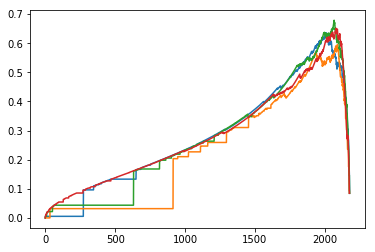

In [19]:
clf = []
val_mcc = []
val_pred = pd.DataFrame([])
proba = []
lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'None',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'binary', 
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }


for train_idx, val_idx in skf.split(train, target):
    X_tr, y_tr = train.iloc[train_idx, :], target[train_idx]
    X_val, y_val = train.iloc[val_idx, :], target[val_idx]
    
    print(pd.Series(y_val).value_counts()[1]/len(y_val))
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30, feval=mcc_eval)
    pred_lgb = model_lgb.predict(X_val)
    
    best_proba, best_mcc, y_pred = eval_mcc(y_val, pred_lgb, show=True)
    val_mcc.append(best_mcc)
    proba.append(best_proba)
    
    pred_lgb = pd.DataFrame(pred_lgb, index=val_idx)
    val_pred = pd.concat([val_pred, pred_lgb], axis=1)
    
    clf.append(model_lgb)

In [20]:
proba

[0.39770002887427763,
 0.5927372402054318,
 0.5403531557270141,
 0.13840794871949272]

In [21]:
val_mcc

[0.6362515420283368, 0.5953715864861232, 0.678959950921099, 0.6512537714126739]

In [22]:
np.mean(val_mcc)

0.6404592127120582

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(target, (np.sum(val_pred, axis=1)>np.mean(proba)).astype(int))

array([[8024,  163],
       [ 231,  294]])

0.5917407033398319 0.5917407033398319


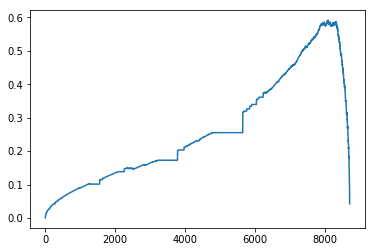

In [24]:
best_proba, best_mcc, y_pred = eval_mcc(target, np.sum(val_pred, axis=1), show=True)

In [25]:
feature_imp = np.zeros(train.shape[1])
for model in clf:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp/4, index=train.columns).sort_values(by=0, ascending=False)

,0
NumNegPeaks_ID,4642.910958
StdAmp_ID,2844.113812
StdAmpPos_ID,758.796643
MinAmp_ID,753.551620
MeanAmpNeg_ID,458.481939
NumPosPeaks_ID,350.282550
MeanAmpPos_ID,286.447721
NumPeaks_ID,265.110015
MeanAmp_ID,259.278345
MeanAmpAll_AD,236.560764


In [26]:
feature_imp = []
for model in clf:
    feature_imp.append(model.feature_importance(importance_type='gain'))

pd.DataFrame(feature_imp, columns=train.columns).T.sort_values(by=0, ascending=False)

,0,1,2,3
NumNegPeaks_ID,4981.542401,4736.309238,4175.150340,4678.641853
StdAmp_ID,2300.017388,2687.989474,3579.554080,2808.894308
StdAmpPos_ID,867.605642,1282.247867,200.881360,684.451703
MinAmp_ID,819.838281,591.295831,995.096328,607.976040
MeanAmpPos_ID,409.768794,204.742320,170.610480,360.669292
NumPeaks_ID,403.641962,199.710600,324.826598,132.260899
MeanAmp_ID,402.719570,180.454779,175.762712,278.176321
NumPosPeaks_ID,348.086541,317.873549,160.950521,574.219591
MeanAmpAll_AD,290.645945,265.828678,104.962683,284.805752
MeanAmpNeg_ID,272.675851,157.807150,535.322437,868.122319


In [27]:
pred_lgb

,0
6277,0.290314
6278,0.341020
6282,0.064095
6283,0.074419
6284,0.057963
6303,0.914378
6304,0.923363
6305,0.921344
6351,0.902777
6352,0.864454


In [28]:
X_val

,id_measurement,phase,NumPeaks,NumPosPeaks,NumNegPeaks,MaxWidth,MinWidth,MeanWidth,MaxAmp,MinAmp,MeanAmp,StdAmpAll,StdPosAll,StdWidthAll,StdAmpQ2,StdPosQ2,StdWidthQ2,StdAmpQ3,StdPosQ3,StdWidthQ3,StdAmpQ4,StdPosQ4,StdWidthQ4,StdAmpAll_AD,StdAmpQ2_AD,StdAmpQ3_AD,StdAmpQ4_AD,MeanAmpAll_AD,MeanAmpQ2_AD,MeanAmpQ3_AD,MeanAmpQ4_AD,MeanAmpPos,MeanAmpNeg,NumPeaks_ID,NumPosPeaks_ID,NumNegPeaks_ID,MaxAmp_ID,MinAmp_ID,MeanAmp_ID,MeanAmpPos_ID,MeanAmpNeg_ID,StdAmp_ID,StdAmpPos_ID,StdAmpNeg_ID
6277,2092,1,966,473,493,30731,1,413.330570,144.340815,-120.318165,-1.108098e-03,34.570905,122257.300778,1495.271979,35.446054,16422.991515,717.054450,39.544058,20059.434329,1397.876592,29.906029,19981.822509,1457.953654,189.207128,213.833297,175.655239,182.165874,8.656248e+01,1.204001e+02,72.088697,78.752273,29.966055,-29.649459,1611.0,781.0,830.0,144.340815,-120.318165,-0.003541,-26.637198,26.494702,1.969527,14.697162,17.352940
6278,2092,2,502,230,272,44402,1,792.722555,52.971595,-55.138397,-2.492199e-03,21.543446,124396.688419,2873.648277,21.351101,13359.614306,1073.328340,22.174669,23971.861889,1531.509267,19.825653,14911.156110,3593.061087,140.840618,169.541015,131.703416,100.879017,4.344718e+01,6.624098e+01,37.513792,21.268380,20.354050,-20.876144,1611.0,781.0,830.0,144.340815,-120.318165,-0.003541,-26.637198,26.494702,1.969527,14.697162,17.352940
6282,2094,0,429,224,205,20832,1,927.182243,26.890641,-36.772834,2.828086e-04,6.595668,100586.466064,1596.001508,6.136274,32406.405994,1434.691480,8.675457,28880.375909,1095.491004,5.644342,31594.333973,2923.124244,105.687041,78.065026,162.481181,85.295516,2.343826e+01,1.249903e+01,60.003245,15.000172,5.260240,-5.195953,803.0,401.0,402.0,19.113553,-36.772834,-0.001010,-4.941393,3.945895,0.266224,4.860291,2.640039
6283,2094,1,160,85,75,23339,1,2150.591195,14.963182,-7.744567,2.088087e-04,4.309100,79999.415148,3932.229264,3.560900,31267.051043,3308.463809,4.098160,21521.503493,2907.108108,4.650890,23458.906307,5254.117656,87.835438,65.565310,139.441146,74.153530,1.593852e+01,8.748813e+00,42.504370,11.251333,4.216216,-3.664731,803.0,401.0,402.0,19.113553,-36.772834,-0.001010,-4.941393,3.945895,0.266224,4.860291,2.640039
6284,2094,2,434,208,226,17130,1,920.725173,16.994428,-29.009418,-1.501958e-03,6.672808,87685.957470,1614.198984,5.185889,25569.560837,1691.165878,7.670978,22177.068501,842.107160,5.638021,32152.179818,3018.983330,107.017681,97.982184,148.321312,88.664075,2.406116e+01,1.999777e+01,48.747948,16.250089,4.133374,-6.462499,803.0,401.0,402.0,19.113553,-36.772834,-0.001010,-4.941393,3.945895,0.266224,4.860291,2.640039
6303,2101,0,367,201,166,28921,1,1090.672131,50.712517,-63.296897,1.318779e-03,14.635193,126645.610268,2511.784288,13.014879,22463.908032,1574.390361,17.474320,21351.184247,2368.501681,12.856464,22235.324575,1084.488806,164.971227,191.302142,110.933878,197.019904,6.214856e+01,8.905467e+01,25.954534,96.088460,13.586456,-13.273289,1896.0,947.0,949.0,173.177004,-91.970548,0.002718,-15.719462,16.900539,1.425869,10.687472,14.527321
6304,2101,1,818,398,420,17990,1,488.592411,173.177004,-100.559766,1.667427e-03,27.035486,120580.235464,1152.166255,24.551361,26879.418847,501.653362,26.029137,23316.379986,2557.879984,27.775417,25345.299745,480.388878,185.040439,214.317370,133.703513,215.799653,8.187659e+01,1.212512e+02,38.755347,123.752146,23.230799,-20.425922,1896.0,947.0,949.0,173.177004,-91.970548,0.002718,-15.719462,16.900539,1.425869,10.687472,14.527321
6305,2101,2,985,486,499,34189,1,404.896341,43.133357,-56.485236,-2.686041e-04,12.354916,121660.925657,1648.824537,13.012476,20826.198911,572.835368,12.292745,17602.325911,1739.597633,11.550030,19881.565325,542.540341,155.667841,172.193945,111.521988,189.985973,5.437733e+01,6.874830e+01,26.256000,87.507105,11.407409,-11.325536,1896.0,947.0,949.0,173.177004,-91.970548,0.002718,-15.719462,16.900539,1.425869,10.687472,14.527321
6351,2117,0,245,116,129,37973,1,1631.827869,34.419367,-29.628830,-3.994462e-04,15.834561,117865.188244,3775.518950,15.1

In [29]:
pd.Series(y_val).value_counts()[1]/len(y_val)

0.060174552135966924

In [30]:
numpeaks = np.load('../features/numpeaks_test.npy')
numpospeaks = np.load('../features/numpospeaks_test.npy')
numnegpeaks = np.load('../features/numnegpeaks_test.npy')

maxpeakwidth = np.load('../features/maxpeakwidth_test.npy')
minpeakwidth = np.load('../features/minpeakwidth_test.npy')
meanpeakwidth = np.load('../features/meanpeakwidth_test.npy')
maxamp = np.load('../features/maxamp_test.npy')
minamp = np.load('../features/minamp_test.npy')
meanamp = np.load('../features/meanamp_test.npy')

stdampall = np.load('../features/stdampall_test.npy')
stdposall = np.load('../features/stdposall_test.npy')
stdwidthall = np.load('../features/stdwidthall_test.npy')

stdampq2 = np.load('../features/stdampq2_test.npy')
stdposq2 = np.load('../features/stdposq2_test.npy')
stdwidthq2 = np.load('../features/stdwidthq2_test.npy')
stdampq3 = np.load('../features/stdampq3_test.npy')
stdposq3 = np.load('../features/stdposq3_test.npy')
stdwidthq3 = np.load('../features/stdwidthq3_test.npy')
stdampq4 = np.load('../features/stdampq4_test.npy')
stdposq4 = np.load('../features/stdposq4_test.npy')
stdwidthq4 = np.load('../features/stdwidthq4_test.npy')


In [31]:
stdampall_ad = np.load('../features/stdampall_ad_test.npy')
stdampq2_ad = np.load('../features/stdampq2_ad_test.npy')
stdampq3_ad = np.load('../features/stdampq3_ad_test.npy')
stdampq4_ad = np.load('../features/stdampq4_ad_test.npy')

meanampall_ad = np.load('../features/meanampall_ad_test.npy')
meanampq2_ad = np.load('../features/meanampq2_ad_test.npy')
meanampq3_ad = np.load('../features/meanampq3_ad_test.npy')
meanampq4_ad = np.load('../features/meanampq4_ad_test.npy')

meanamppos = np.load('../features/meanamppos_test.npy')
meanampneg = np.load('../features/meanampneg_test.npy')


In [32]:
numpeaks_id = np.load('../features/numpeaks_id_test.npy')
numpospeaks_id = np.load('../features/numpospeaks_id_test.npy')
numnegpeaks_id = np.load('../features/numnegpeaks_id_test.npy')

maxamp_id = np.load('../features/maxamp_id_test.npy')
minamp_id = np.load('../features/minamp_id_test.npy')
meanamp_id = np.load('../features/meanamp_id_test.npy')

meanamppos_id = np.load('../features/meanamppos_id_test.npy')
meanampneg_id = np.load('../features/meanampneg_id_test.npy')


In [33]:
stdamp_id_test = np.load('../features/stdamp_id_test.npy')
stdamppos_id_test = np.load('../features/stdamppos_id_test.npy')
stdampneg_id_test = np.load('../features/stdampneg_id_test.npy')

In [34]:
test_features = pd.DataFrame({'NumPeaks':numpeaks, 'NumPosPeaks':numpospeaks, 'NumNegPeaks':numnegpeaks, 'MaxWidth':maxpeakwidth,
                         'MinWidth':minpeakwidth, 'MeanWidth':meanpeakwidth, 'MaxAmp':maxamp, 'MinAmp':minamp, 'MeanAmp':meanamp,
                        'StdAmpAll':stdampall, 'StdPosAll':stdposall, 'StdWidthAll':stdwidthall, 'StdAmpQ2':stdampq2, 'StdPosQ2':stdposq2,
                         'StdWidthQ2':stdwidthq2, 'StdAmpQ3':stdampq3, 'StdPosQ3':stdposq3, 'StdWidthQ3':stdwidthq3,
                        'StdAmpQ4':stdampq4, 'StdPosQ4':stdposq4, 'StdWidthQ4':stdwidthq4, 
                        'StdAmpAll_AD':stdampall_ad, 'StdAmpQ2_AD': stdampq2_ad, 'StdAmpQ3_AD': stdampq3_ad, 'StdAmpQ4_AD': stdampq4_ad,
                        'MeanAmpAll_AD':meanampall_ad, 'MeanAmpQ2_AD': meanampq2_ad,
                        'MeanAmpQ3_AD': meanampq3_ad, 'MeanAmpQ4_AD': meanampq4_ad,
                        'MeanAmpPos':meanamppos, 'MeanAmpNeg':meanampneg,
                        'NumPeaks_ID':numpeaks_id[0:20000], 'NumPosPeaks_ID':numpospeaks_id[0:20000], 'NumNegPeaks_ID':numnegpeaks_id[0:20000],
                        'MaxAmp_ID':maxamp_id[0:20000], 'MinAmp_ID':minamp_id[0:20000], 'MeanAmp_ID':meanamp_id[0:20000],
                        'MeanAmpPos_ID':meanamppos_id[0:20000], 'MeanAmpNeg_ID':meanampneg_id[0:20000],
                        'StdAmp_ID':stdamp_id_test[0:20000], 'StdAmpPos_ID':stdamppos_id_test[0:20000],
                        'StdAmpNeg_ID':stdampneg_id_test[0:20000], 
                        })

In [35]:
test = pd.concat([meta_test, test_features], axis=1)

In [36]:
test_id = test['signal_id'].values
del test['signal_id']

In [37]:
preds = None
for model in clf:
    if preds is None:
        preds = model.predict(test)
    else:
        preds += model.predict(test)
    
preds = preds/4

In [38]:
submission = pd.DataFrame({'signal_id':test_id,'target':(preds>best_proba).astype(int)})

In [39]:
submission.to_csv('../output/submission_10.csv', index=False)

In [40]:
best_proba

0.2304554909058832

In [41]:
np.max(preds)

0.6799958147041558

In [42]:
pd.Series((preds>best_proba).astype(int)).value_counts()

0    19868
1      469
dtype: int64